We start by defining the Neural ODE model for system identification

In [1]:
# Code adopted from paper 'BEAR-Data: Analysis and Applications of an Open Multizone Building Dataset'
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time

# For this example, we use cpu for simplicity.
use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
BoolTensor = torch.cuda.BoolTensor if use_cuda else torch.BoolTensor
Tensor = FloatTensor

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.manual_seed(1234)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('font', size=13) 

In [2]:
"""
System Idenfication: learning odefunc theta
Input:
    x0: initial state
    y: action, disturbance
    t: time index
Output:
    x: state trajectory
"""
class PhysicODE(nn.Module):
    def __init__(self, n=9):
        super(PhysicODE, self).__init__()
        self.rij = [nn.Parameter(torch.ones(1)*1e-4) for _ in range(n)]
        self.p = nn.Parameter(torch.randn(1))
        self.cp = nn.Parameter(torch.randn(1))
        self.tp =  nn.Parameter(Tensor([1.8]))
        self.encode = nn.Sequential(
            nn.Linear(2, 6), nn.Tanh(),
            nn.Linear(6, 1)
        )
        self.encode2 = nn.Sequential(
            nn.Linear(11, 12), nn.Tanh(),
            nn.Linear(12, 1)
        )
        self.step = torch.tensor(1.0)
        self.grid_constructor = self._grid_constructor_from_step_size(self.step)

    @staticmethod
    def _grid_constructor_from_step_size(step_size):
        """
        Inputs: step size
        Returns: _grid_constructor #to build a grid search table
        """
        def _grid_constructor(t):
            start_time = t[0]
            end_time = t[-1]

            niters = torch.ceil((end_time - start_time) / step_size + 1).item()
            t_infer = torch.arange(0, niters, dtype=t.dtype, device=t.device) * step_size + start_time
            t_infer[-1] = t[-1]

            return t_infer
        return _grid_constructor

    def _step_func(self, y0, name=None):
        """
        Inputs:
            y0: (B, 11) -- current room + 9 room + action
        Returns:
            dx: (B, 1)
        """
        if name == 'C1': # Combined approach
            dx = torch.sum(torch.stack([1 * self.rij[i] * (y0[:,i+1:i+2]-y0[:,0:1]) for i in range(9)], dim=0), dim=0)
            dx += self.encode(torch.cat((y0[:,-1:], y0[:,0:1]),dim=1))
        elif name == 'P1': # Physic-Based approach
            dx = torch.sum(torch.stack([1 * self.rij[i] * (y0[:,i+1:i+2]-y0[:,0:1]) for i in range(9)], dim=0), dim=0)
            dx += self.cp * y0[:,-1:] * (torch.ones(1)*self.tp - y0[:,0:1]) + self.p
        elif name == 'D1': # Model-free approach
            dx = self.encode2(y0)
        return dx

    def forward(self, x0, y, t, name=None):
        """
        Integrate function
        Inputs:
            x0: (B, 1)       # all room's temperature + amb_temperature
            y:  (L, B, 1)    # current room action
            t:  (L)          # time (length)
        Returns:
            x: (L, B, 1)     # room's future temperature
        """
        time_grid = self.grid_constructor(t)
        solution = [x0]

        j = 1
        for t0, t1 in zip(time_grid[:-1], time_grid[1:]):
            y0 = torch.cat((x0, y[j-1]), dim=1)
            dx = self._step_func(y0, name=name)
            x1 = x0 + dx

            while j < len(t) and t1 >= t[j]:
                solution.append(self._linear_interp(t0, t1, x0, x1, t[j]))
                j += 1
            x0 = x1

        return torch.stack(solution)

    def _linear_interp(self, t0, t1, y0, y1, t):
        # Linear interpolation
        if t == t0:
            return y0
        if t == t1:
            return y1
        slope = (t - t0) / (t1 - t0)
        return y0 + slope * (y1 - y0)


# Dataset generation
We load data from the BEAR dataset to train the models

In [3]:
from torch.utils.data import Dataset
torch.manual_seed(1234)

def transform(x, length=2, day=14):
    """
    Transform the input data for unit conversion and reshaping.

    Args:
        x (numpy.ndarray): Input array of shape (T, day*B).
        length (int): Length of each segment.
        day (int): Number of days.

    Returns:
        numpy.ndarray: Transformed data reshaped and scaled.
    """
    # Transpose x to bring day*B to the first dimension for easier processing
    x = np.transpose(x, (1, 0, 2))  # Shape becomes (day*B, T, feature)

    # Initialize the transformed data array
    transformed_data = []

    # Loop through each day to process the data
    for d in range(day):
        # Collect segments for the current day based on length
        segments = x[[d + day * i for i in range(96 // length)]]
        # Reshape and flatten segments for the current day
        transformed_day = segments.reshape(-1)
        transformed_data.append(transformed_day)

    # Combine all days, scale, and offset
    result = np.concatenate(transformed_data) * 10 + 40
    return result

class BuildingDataset(Dataset):
    """
    A PyTorch dataset for building control tasks.
    """
    def __init__(self, file, room=0, N_train=7, length=10, resolution=3, normalize=True, train=True):
        """
        Initializes the dataset.

        Parameters:
        - file (str): Path to the dataset file (.npz format).
        - room (int): Index of the room to control (default is 0). Different rooms have different patterns, and different method may excel.
        - N_train (int): Number of days for training set. (default is 7).
        - length (int): Length of each sequence in time steps (default is 10).
        - resolution (int): Sampling resolution (e.g., every 3rd time step) (default is 3).
        - normalize (bool): Whether to normalize the data (default is True).
        - train (bool): Whether to load training or test data (default is True).
        """
        self.file = file
        data = np.load(file)
        if train:
            # Select training trajectories with specified resolution.
            xx = Tensor(np.transpose(data['state'], (1,0,2)))[::resolution, :N_train, :]   # shape (T, N, 10)
            uu = Tensor(np.transpose(data['action'],(1,0,2)))[::resolution, :N_train, room:room+1]  # shape (T, N, 1)
        else:
            xx = Tensor(np.transpose(data['state'], (1,0,2)))[::resolution, N_train:2*N_train, :]   # shape (T, N, 10)
            uu = Tensor(np.transpose(data['action'],(1,0,2)))[::resolution, N_train:2*N_train, room:room+1]  # shape (T, N, 1)
        if normalize:
            xx = (xx - 40) / 10
            uu = uu / 100
        # Prepare the input features `yy` by concatenating relevant states and actions.
        yy = torch.cat((xx[:,:,list(set(range(10))-set([room]))], uu), dim=-1) # (T, N, 10)
        T = xx.shape[0]

        # Initialize lists to store processed data.
        x0 = []  # Initial state for each sequence.
        truex = []  # True states for the specified room.
        y = []  # Features for training the model.

        # Slice the data into sequences of the specified length.
        for t in range(0, T - length + 1, length):
            x0.append(xx[t, :, room:room+1])  # Initial state for this sequence.
            truex.append(xx[t:t+length, :, room:room+1])  # True trajectory for this sequence.
            y.append(yy[t:t+length-1])  # Features for predicting the next state.
    
        self.x0 = torch.cat(x0, dim=0)                     # (B, 1)
        self.truex = torch.cat(truex, dim=1)            # (L+1, B, 1)
        self.y = torch.cat(y, dim=1)                    # (L+1, B, 1)
        print('Prepare dataset...: x.shape', self.truex.shape)

    def __len__(self):
        return len(self.x0)

    def __getitem__(self, idx):
        x0 = self.x0[idx]
        y = self.y[:,idx]
        truex = self.truex[:, idx]
        return x0, y, truex

# Train the models

In [4]:
torch.manual_seed(1234)

def train(model, room=0, num_epochs=500, length=2, save=False, save_name=None, model_name=None):
    """
    Train a given model using the BEAR dataset.

    Args:
        model: The model to train.
        room: Room index for the dataset (default=0).
        num_epochs: Total number of training epochs (default=500).
        length: Sequence length for each training sample (default=2, repesent 15 mins, 1 unit = 15 mins, 2->current+predict, 3hr->1+12=13). 
        save: Boolean flag to save the model (default=False).
        save_name: File name to save the best model (if save=True).
        model_name: Optional identifier for the model (default=None).

    Returns:
        Trained model.
    """
    # Define the time steps for the sequence length
    t = torch.linspace(0, length, length)

    # Print sequence length for debugging
    print(length)

    # Load the training and validation datasets
    dataset1 = BuildingDataset(file='control_data.npz', N_train=7, room=room, length=length, resolution=3, train=True)
    dataset2 = BuildingDataset(file='control_data.npz', N_train=7, room=room, length=length, resolution=3, train=False)

    # Create data loaders for batching and shuffling
    dataloader = DataLoader(dataset1, batch_size=128, shuffle=False)
    val_loader = DataLoader(dataset2, batch_size=256, shuffle=False)

    # Set up optimizer, scheduler, and loss function
    lr = 1e-1  # Initial learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)  # Learning rate scheduler
    loss_fun = torch.nn.MSELoss()  # Mean Squared Error loss

    # Initialize variables to track the best model and training progress
    min_loss = 100000
    Val_Loss = []  # Store validation loss for each epoch
    Loss = []  # Store training loss for each epoch
    val_loss, cnt = 100, 0  # Initialize validation loss and patience counter

    # Start timing the training process
    start = time.time()

    ##################################################################
    # Training loop for the specified number of epochs
    for epoch in range(num_epochs):
        # Adjust learning rate manually at specific epochs for fine-tuning
        if epoch == 500:
            optimizer.param_groups[0]['lr'] = 1e-2
        elif epoch == 2000:
            optimizer.param_groups[0]['lr'] = 1e-3

        train_loss = 0.0  # Initialize training loss for this epoch

        # Training phase
        for x0, y, truex in dataloader:
            # Permute dimensions to match the expected input shape
            y = y.permute(1, 0, 2)
            truex = truex.permute(1, 0, 2)

            # Forward pass
            predx = model(x0, y, t, name=model_name)  # Model prediction

            # Compute loss
            loss = loss_fun(predx * 10, truex * 10)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()  # Accumulate loss

        train_loss /= len(dataloader)  # Average training loss for this epoch

        # Save the best model if the current training loss is the minimum
        if save and train_loss < min_loss:
            best_model = model
            torch.save(best_model.state_dict(), save_name)
            min_loss = train_loss

        Loss.append(train_loss)  # Record training loss

        # Validation phase
        model.eval()
        pre_loss = val_loss  # Store the previous validation loss
        val_loss = 0.0  # Initialize validation loss for this epoch

        with torch.no_grad():  # Disable gradient calculation for validation
            for x0, y, truex in val_loader:
                y = y.permute(1, 0, 2)
                truex = truex.permute(1, 0, 2)
                predx = model(x0, y, t, name=model_name)
                loss = loss_fun(predx * 10, truex * 10)
                val_loss += loss.item()

        val_loss /= len(val_loader)  # Average validation loss

        # Adjust learning rate or stop training if validation loss doesn't improve
        if val_loss > pre_loss:
            cnt += 1
            if cnt > 100:  # Stop early if no improvement for 100 epochs
                break
            elif cnt > 10:  # Halve learning rate if no improvement for 10 epochs
                optimizer.param_groups[0]['lr'] /= 2
        else:
            cnt = 0  # Reset patience counter if validation loss improves

        Val_Loss.append(val_loss)  # Record validation loss

        # Print progress every 50 epochs
        if epoch % 50 == 0:
            print(f'Epoch = {epoch}, Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Time Used: {np.round(time.time()-start, 2)}s')

    # Save loss data for future analysis
    np.savez(f'{save_name}_{room}_loss.npz', loss=np.array(Loss), val_loss=np.array(Val_Loss))

    return model  # Return the trained model

In [5]:
#3 hr horizon (length=13)  current 1 + predict 12 = 13
torch.manual_seed(1234)
model_P_room_2_hori_3h = PhysicODE()
e = 4000
model_P_room_2_hori_3h=train(model_P_room_2_hori_3h,room=2,num_epochs=e,length=13,save=True,save_name=f'checkpoint/p_room_2_hori_3h.pth',model_name='P1')

13
Prepare dataset...: x.shape torch.Size([13, 49, 1])
Prepare dataset...: x.shape torch.Size([13, 49, 1])
Epoch = 0, Train Loss = 225.0418, Val Loss = 116.7585, Time Used: 0.04s
Epoch = 50, Train Loss = 1.5087, Val Loss = 16.4362, Time Used: 0.59s
Epoch = 100, Train Loss = 1.4541, Val Loss = 17.0524, Time Used: 1.14s
Epoch = 150, Train Loss = 1.4541, Val Loss = 17.0515, Time Used: 1.69s
Epoch = 200, Train Loss = 1.4541, Val Loss = 17.0504, Time Used: 2.23s
Epoch = 250, Train Loss = 1.4541, Val Loss = 17.0491, Time Used: 2.78s
Epoch = 300, Train Loss = 1.4541, Val Loss = 17.0476, Time Used: 3.34s
Epoch = 350, Train Loss = 1.4540, Val Loss = 17.0459, Time Used: 3.89s
Epoch = 400, Train Loss = 1.4540, Val Loss = 17.0441, Time Used: 4.43s
Epoch = 450, Train Loss = 1.4540, Val Loss = 17.0421, Time Used: 4.97s
Epoch = 500, Train Loss = 1.4540, Val Loss = 16.9690, Time Used: 5.51s
Epoch = 550, Train Loss = 1.4314, Val Loss = 13.4689, Time Used: 6.06s
Epoch = 600, Train Loss = 1.4198, Val Los

In [6]:
#3 hr horizon (length=12)
torch.manual_seed(1234)
model_C_room_2_hori_3h = PhysicODE()
e = 4000
model_C_room_2_hori_3h=train(model_C_room_2_hori_3h,room=2,num_epochs=e,length=13,save=True,save_name=f'checkpoint/c_room_2_hori_3h.pth',model_name='C1')

13
Prepare dataset...: x.shape torch.Size([13, 49, 1])
Prepare dataset...: x.shape torch.Size([13, 49, 1])
Epoch = 0, Train Loss = 333.5693, Val Loss = 610.8842, Time Used: 0.02s
Epoch = 50, Train Loss = 0.6352, Val Loss = 2.4768, Time Used: 0.63s
Epoch = 100, Train Loss = 0.4411, Val Loss = 1.1216, Time Used: 1.23s
Epoch = 150, Train Loss = 0.4091, Val Loss = 1.0776, Time Used: 1.84s
Epoch = 200, Train Loss = 0.3752, Val Loss = 0.9076, Time Used: 2.46s
Epoch = 250, Train Loss = 0.3312, Val Loss = 0.6491, Time Used: 3.06s
Epoch = 300, Train Loss = 0.2749, Val Loss = 0.3311, Time Used: 3.67s
Epoch = 350, Train Loss = 0.2158, Val Loss = 0.1168, Time Used: 4.28s
Epoch = 400, Train Loss = 0.1879, Val Loss = 0.1036, Time Used: 4.93s
Epoch = 450, Train Loss = 0.1879, Val Loss = 0.1036, Time Used: 5.54s
Epoch = 500, Train Loss = 0.1879, Val Loss = 0.1037, Time Used: 6.12s
Epoch = 550, Train Loss = 0.1872, Val Loss = 0.1047, Time Used: 6.72s
Epoch = 600, Train Loss = 0.1872, Val Loss = 0.1047,

In [7]:
#3 hr horizon (length=12)
torch.manual_seed(1234)
model_D_room_2_hori_3h = PhysicODE()
e = 4000
model_D_room_2_hori_3h=train(model_D_room_2_hori_3h,room=2,num_epochs=e,length=13,save=True,save_name=f'checkpoint/d_room_2_hori_3h.pth',model_name='D1')

13
Prepare dataset...: x.shape torch.Size([13, 49, 1])
Prepare dataset...: x.shape torch.Size([13, 49, 1])
Epoch = 0, Train Loss = 797.0471, Val Loss = 11243.9736, Time Used: 0.01s
Epoch = 50, Train Loss = 2.5344, Val Loss = 1.8507, Time Used: 0.2s
Epoch = 100, Train Loss = 0.2520, Val Loss = 0.1342, Time Used: 0.41s
Epoch = 150, Train Loss = 0.2167, Val Loss = 0.1274, Time Used: 0.61s
Epoch = 200, Train Loss = 0.2161, Val Loss = 0.1273, Time Used: 0.83s
Epoch = 250, Train Loss = 0.2158, Val Loss = 0.1272, Time Used: 1.06s
Epoch = 300, Train Loss = 0.2154, Val Loss = 0.1271, Time Used: 1.28s
Epoch = 350, Train Loss = 0.2149, Val Loss = 0.1270, Time Used: 1.5s
Epoch = 400, Train Loss = 0.2143, Val Loss = 0.1268, Time Used: 1.72s
Epoch = 450, Train Loss = 0.2135, Val Loss = 0.1266, Time Used: 1.95s
Epoch = 500, Train Loss = 0.2125, Val Loss = 0.1264, Time Used: 2.16s
Epoch = 550, Train Loss = 0.2122, Val Loss = 0.1263, Time Used: 2.38s
Epoch = 600, Train Loss = 0.2117, Val Loss = 0.1261,

In [8]:
torch.manual_seed(1234)
e=4000
model_P_room_2_hori_15m = PhysicODE()
model_P_room_2_hori_15m = train(model_P_room_2_hori_15m,room=2,num_epochs=e,save=True,save_name=f'checkpoint/p_room_2_hori_15.pth',model_name='P1')

2
Prepare dataset...: x.shape torch.Size([2, 336, 1])
Prepare dataset...: x.shape torch.Size([2, 336, 1])
Epoch = 0, Train Loss = 35.2303, Val Loss = 15.0445, Time Used: 0.02s
Epoch = 50, Train Loss = 0.0140, Val Loss = 0.0121, Time Used: 0.47s
Epoch = 100, Train Loss = 0.0138, Val Loss = 0.0123, Time Used: 0.9s
Epoch = 150, Train Loss = 0.0137, Val Loss = 0.0123, Time Used: 1.33s
Epoch = 200, Train Loss = 0.0137, Val Loss = 0.0123, Time Used: 1.77s
Epoch = 250, Train Loss = 0.0137, Val Loss = 0.0123, Time Used: 2.2s
Epoch = 300, Train Loss = 0.0137, Val Loss = 0.0123, Time Used: 2.62s
Epoch = 350, Train Loss = 0.0137, Val Loss = 0.0123, Time Used: 3.03s
Epoch = 400, Train Loss = 0.0137, Val Loss = 0.0123, Time Used: 3.45s
Epoch = 450, Train Loss = 0.0137, Val Loss = 0.0123, Time Used: 3.87s
Epoch = 500, Train Loss = 0.0137, Val Loss = 0.0123, Time Used: 4.29s
Epoch = 550, Train Loss = 0.0138, Val Loss = 0.0123, Time Used: 4.71s
Epoch = 600, Train Loss = 0.0138, Val Loss = 0.0123, Time

In [9]:
torch.manual_seed(1234)
model_C_room_2_hori_15m = PhysicODE()
model_names= ['D1', 'P1', 'C1']
e = 4000
model_C_room_2_hori_15m=train(model_C_room_2_hori_15m,room=2,num_epochs=e,save=True,save_name=f'checkpoint/c_room_2_hori_15.pth',model_name='C1')

2
Prepare dataset...: x.shape torch.Size([2, 336, 1])
Prepare dataset...: x.shape torch.Size([2, 336, 1])
Epoch = 0, Train Loss = 20.6091, Val Loss = 8.7316, Time Used: 0.02s
Epoch = 50, Train Loss = 0.0131, Val Loss = 0.0153, Time Used: 0.49s
Epoch = 100, Train Loss = 0.0130, Val Loss = 0.0149, Time Used: 0.95s
Epoch = 150, Train Loss = 0.0132, Val Loss = 0.0148, Time Used: 1.46s
Epoch = 200, Train Loss = 0.0135, Val Loss = 0.0145, Time Used: 1.95s
Epoch = 250, Train Loss = 0.0138, Val Loss = 0.0142, Time Used: 2.42s
Epoch = 300, Train Loss = 0.0127, Val Loss = 0.0148, Time Used: 2.88s
Epoch = 350, Train Loss = 0.0125, Val Loss = 0.0151, Time Used: 3.35s
Epoch = 400, Train Loss = 0.0125, Val Loss = 0.0151, Time Used: 3.82s
Epoch = 450, Train Loss = 0.0125, Val Loss = 0.0151, Time Used: 4.29s
Epoch = 500, Train Loss = 0.0127, Val Loss = 0.0149, Time Used: 4.75s
Epoch = 550, Train Loss = 0.0125, Val Loss = 0.0154, Time Used: 5.22s
Epoch = 600, Train Loss = 0.0125, Val Loss = 0.0154, Tim

In [10]:
torch.manual_seed(1234)
model_D_room_2_hori_15m = PhysicODE()
model_names= ['D1', 'P1', 'C1']
e = 4000
model_D_room_2_hori_15m=train(model_D_room_2_hori_15m,room=2,num_epochs=e,save=True,save_name=f'checkpoint/d_room_2_hori_15.pth',model_name='D1')

2
Prepare dataset...: x.shape torch.Size([2, 336, 1])
Prepare dataset...: x.shape torch.Size([2, 336, 1])
Epoch = 0, Train Loss = 231.9325, Val Loss = 5.0356, Time Used: 0.01s
Epoch = 50, Train Loss = 0.0149, Val Loss = 0.0122, Time Used: 0.35s
Epoch = 100, Train Loss = 0.0159, Val Loss = 0.0122, Time Used: 0.67s
Epoch = 150, Train Loss = 0.0151, Val Loss = 0.0125, Time Used: 1.0s
Epoch = 200, Train Loss = 0.0133, Val Loss = 0.0130, Time Used: 1.34s
Epoch = 250, Train Loss = 0.0133, Val Loss = 0.0130, Time Used: 1.69s
Epoch = 300, Train Loss = 0.0133, Val Loss = 0.0130, Time Used: 2.02s
Epoch = 350, Train Loss = 0.0133, Val Loss = 0.0130, Time Used: 2.35s
Epoch = 400, Train Loss = 0.0133, Val Loss = 0.0130, Time Used: 2.75s
Epoch = 450, Train Loss = 0.0133, Val Loss = 0.0130, Time Used: 3.08s
Epoch = 500, Train Loss = 0.0135, Val Loss = 0.0131, Time Used: 3.41s
Epoch = 550, Train Loss = 0.0125, Val Loss = 0.0150, Time Used: 3.78s
Epoch = 600, Train Loss = 0.0125, Val Loss = 0.0149, Tim

# Visualize the trained models

Prepare dataset...: x.shape torch.Size([2, 672, 1])
NN 0.015086166
PINN 0.012237201
PINN+NN 0.01715395
Prepare dataset...: x.shape torch.Size([13, 98, 1])
NN 0.4022171
PINN 0.30358595
PINN+NN 0.33376116


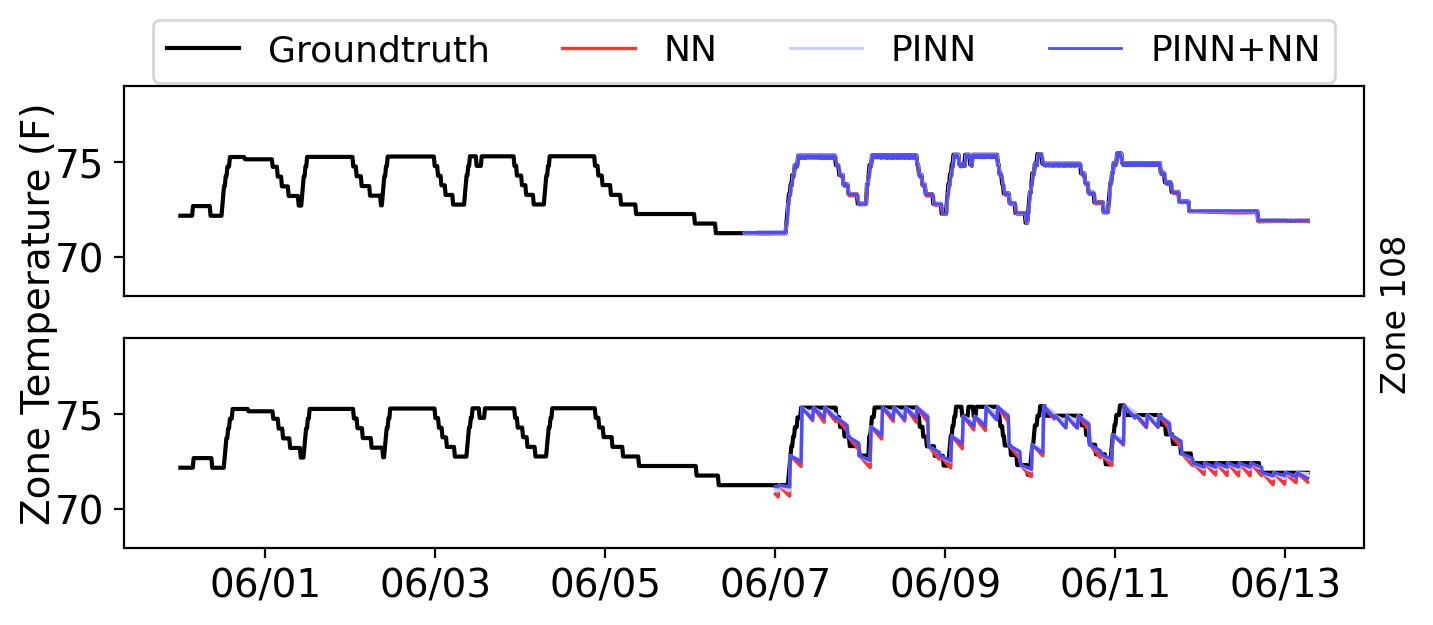

In [12]:
import matplotlib.pyplot as plt

model_names = ['D1', 'P1', 'C1']
model_names2 = ['NN', 'PINN', 'PINN+NN']
colors = ['#ff3534', '#ccccff', '#4c4cff', '#ef857e']
alphas = [1, 1, 1]
lims = [68, 79]
fig, ax = plt.subplots(2, 1, figsize=(8, 3))
room = 2

model_set_1 = [model_D_room_2_hori_15m, model_P_room_2_hori_15m, model_C_room_2_hori_15m]
model_set_2 = [model_D_room_2_hori_3h, model_P_room_2_hori_3h, model_C_room_2_hori_3h]

for i, length in enumerate([2, 13]):
    dataset = BuildingDataset(file='control_data.npz', room=room, N_train=14, length=length, resolution=3, train=False)
    dataloader = DataLoader(dataset, batch_size=20000, shuffle=False)

    for j in range(3):
        model_name = model_names[j]
        model = model_set_1[j] if length == 2 else model_set_2[j]

        t = torch.linspace(0, length, length)
        for x0, y, truex in dataloader:
            y = y.permute(1, 0, 2)  # Ensure proper shape: (L, B, features)
            truex = truex.permute(1, 0, 2).to(device)
            predx = model(x0.to(device), y.to(device), t.to(device), name=model_name)  # Output: (L, B, features)
            break  # Use the first batch

        predx = predx[:truex.shape[0], :, :].cpu().detach().numpy()  # Match sequence lengths
        truex = truex.cpu().detach().numpy()
        y = y.cpu().detach().numpy()

        # Ensure consistent lengths for transform()
        transformed_truex = transform(truex, day=14, length=length)
        transformed_predx = transform(predx, day=14, length=length)

        # Align lengths for plotting
        min_len = min(len(transformed_truex), len(transformed_predx))
        transformed_truex = transformed_truex[:min_len]
        transformed_predx = transformed_predx[:min_len]

        if j == 0:
            ax[i].plot(transformed_truex, color='black', label='Groundtruth', linewidth=1.5)

        ax[i].plot(
            np.arange(672, 672 + len(transformed_predx[672:])),  # Match x length with y
            transformed_predx[672:],
            color=colors[j],
            alpha=alphas[j],
            linewidth=1.2 - 0.1 * j * (i == 0),
            label=model_names2[j]
        )

        print(model_names2[j], np.mean((transformed_predx - transformed_truex) ** 2))

    ax[i].set_xticks([])
    ax[i].set_ylim(lims)
    ax[i].tick_params(labelsize=14)

# Add legend and labels
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=5)
fig.text(0.06, 0.5, 'Zone Temperature (F)', va='center', rotation='vertical', fontsize=14)
fig.text(0.91, 0.5, 'Zone 108', va='center', rotation='vertical', fontsize=12)

# Add x-ticks for the last subplot
tick_positions = list(range(96, 96 * 14, 96 * 2))
tick_labels = ['06/01', '06/03', '06/05', '06/07', '06/09', '06/11', '06/13']
ax[-1].set_xticks(tick_positions)
ax[-1].set_xticklabels(tick_labels, fontsize=14)
plt.savefig('predict.png', dpi=300, bbox_inches='tight')
